<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/10_1000_Arsitektur_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.image as mpimg
import math
import csv
import tensorflow as tf
from tensorflow.keras.models import Sequential

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
# Define the directory containing the dataset
sdir = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Image/Try/10_1000/'

In [10]:
def create_dataframe_from_directory(sdir):
    filepaths = []
    labels = []

    for klass in os.listdir(sdir):
        classpath = os.path.join(sdir, klass)
        if os.path.isdir(classpath):
            file_list = sorted(os.listdir(classpath))
            for idx, f in enumerate(file_list):
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(klass)

    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

def print_class_counts(df):
    class_counts = df['labels'].value_counts()
    for class_name, count in class_counts.items():
        print(f"Class: {class_name}\tCount: {count}")

# Create DataFrame from directory
df = create_dataframe_from_directory(sdir)

# Print class names with their corresponding count of samples
print_class_counts(df)

Class: sepuluh	Count: 150
Class: seribu	Count: 150


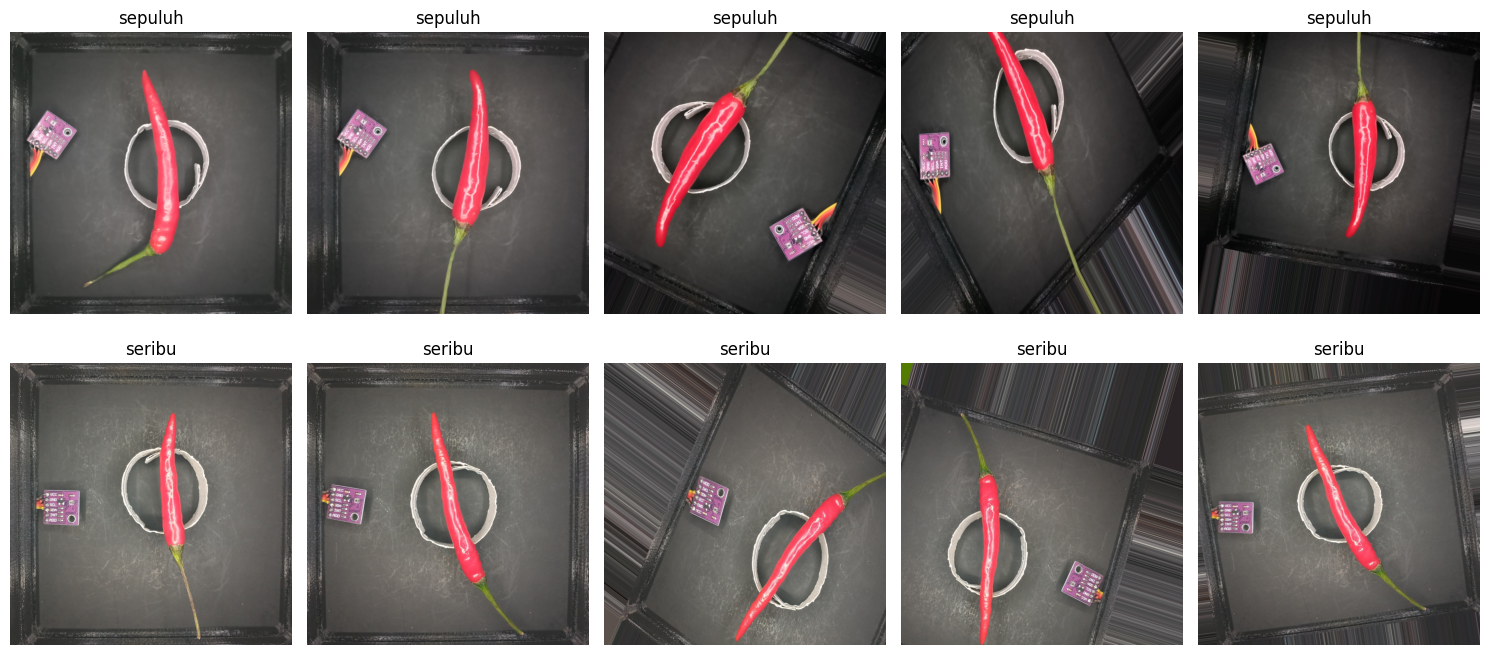

In [11]:
def display_sample_images(df, num_samples=10):
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 7))
    for idx, (class_name, sub_df) in enumerate(df.groupby('labels')):
        if idx == 0:
            ax_row = 0
        else:
            ax_row = 1
        for jdx, (_, row) in enumerate(sub_df.head(num_samples // 2).iterrows()):
            img = mpimg.imread(row['filepaths'])
            axes[ax_row, jdx].imshow(img)
            axes[ax_row, jdx].set_title(f"{row['labels']}")
            axes[ax_row, jdx].axis('off')
    plt.tight_layout()
    plt.show()

# Create DataFrame from directory
df = create_dataframe_from_directory(sdir)

# Display sample images from each class
display_sample_images(df)


In [12]:
import os
import csv
from PIL import Image
import pandas as pd

def image_to_csv(image_folder, output_csv_path):
    # Extract label from the folder path
    label = os.path.basename(image_folder)

    # Check if the input path is a directory
    if os.path.isdir(image_folder):
        # Iterate over all image files in the directory
        for filename in os.listdir(image_folder):
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Process each image file
                process_image(os.path.join(image_folder, filename), label, output_csv_path)

def process_image(image_path, label, output_csv_path):
    # Open the image
    img = Image.open(image_path)

    # Resize the image to 28x28 pixels
    img = img.resize((28, 28), Image.ANTIALIAS)

    # Convert the image to grayscale
    img = img.convert('L')

    # Get pixel data
    pixel_data = list(img.getdata())

    # Flatten the pixel array
    flat_pixel_array = pixel_data

    # Add the label to the beginning of the pixel values
    csv_row = [label] + flat_pixel_array

    # Save pixel values and label to the CSV file
    with open(output_csv_path, 'a', newline='') as csvfile:  # Use 'a' for append mode
        csvwriter = csv.writer(csvfile)
        # Check if the file is empty, if yes, write the header
        if os.stat(output_csv_path).st_size == 0:
            csvwriter.writerow(['label'] + [f'pixel{i + 1}' for i in range(len(flat_pixel_array))])  # Header
        csvwriter.writerow(csv_row)

# Input and output path:
image_folder = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Image/Binary/with_pesticide'
output_csv_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/D/with_pesticide.csv'

# Clear existing content in the CSV file
open(output_csv_path, 'w').close()

image_to_csv(image_folder, output_csv_path)

# Reading Dataset in CSV format
df = pd.read_csv(output_csv_path)

# Drop the first row
df = df.drop([0])

# Display the first few rows of the dataframe
df.head()


<ipython-input-12-8d6eefbac211>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((28, 28), Image.ANTIALIAS)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
1,with_pesticide,36,58,60,41,41,41,47,64,63,...,56,57,64,58,46,40,37,36,36,37
2,with_pesticide,46,40,38,44,47,51,53,55,58,...,14,14,18,21,48,65,75,84,94,95
3,with_pesticide,39,37,45,52,59,62,64,69,72,...,46,86,55,55,45,58,51,59,75,110
4,with_pesticide,40,32,25,19,12,13,11,32,36,...,13,12,10,9,9,9,5,5,5,5
5,with_pesticide,51,56,54,44,31,63,57,43,49,...,29,31,29,32,24,27,29,28,29,34


In [13]:


# Input and output path:
image_folder = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Image/Binary/without_pesticide'
output_csv_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/D/without_pesticide.csv'

# Clear existing content in the CSV file
open(output_csv_path, 'w').close()

image_to_csv(image_folder, output_csv_path)

# Reading Dataset in CSV format
df = pd.read_csv(output_csv_path)

# Drop the first row
df = df.drop([0])

# Display the first few rows of the dataframe
df.head()


<ipython-input-12-8d6eefbac211>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((28, 28), Image.ANTIALIAS)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
1,without_pesticide,87,66,43,48,50,54,67,84,74,...,66,97,79,86,69,52,46,44,42,44
2,without_pesticide,49,53,73,77,81,85,89,93,94,...,76,72,69,69,55,49,57,55,55,55
3,without_pesticide,58,57,58,55,51,48,42,42,46,...,95,96,93,92,88,85,84,75,61,62
4,without_pesticide,59,61,64,63,61,59,63,69,62,...,100,100,98,93,89,86,84,80,78,70
5,without_pesticide,46,43,43,44,45,53,65,68,67,...,66,49,55,50,62,65,66,68,69,68


In [14]:
# Load the datasets
with_pesticide_data = pd.read_csv("/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/D/with_pesticide.csv")
without_pesticide_data = pd.read_csv("/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/D/without_pesticide.csv")

# Split the datasets into features and labels
X_with_pesticide = with_pesticide_data.drop(columns=['label'])  # Assuming 'label' is the column name for the class
y_with_pesticide = with_pesticide_data['label']

X_without_pesticide = without_pesticide_data.drop(columns=['label'])  # Assuming 'label' is the column name for the class
y_without_pesticide = without_pesticide_data['label']

# Split the datasets into training and testing sets (70% train, 30% test)
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_with_pesticide, y_with_pesticide, test_size=0.3, random_state=42)
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_without_pesticide, y_without_pesticide, test_size=0.3, random_state=42)

# Merge the train and test datasets for both classes
X_train = pd.concat([X_train_with, X_train_without])
y_train = pd.concat([y_train_with, y_train_without])
X_test = pd.concat([X_test_with, X_test_without])
y_test = pd.concat([y_test_with, y_test_without])

# Define paths for train and test folders
train_folder = "/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/D/train"
test_folder = "/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Tabular/Binary/D/test"

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Save the datasets into train and test folders
X_train.to_csv(os.path.join(train_folder, 'X_train.csv'), index=False)
y_train.to_csv(os.path.join(train_folder, 'y_train.csv'), index=False)
X_test.to_csv(os.path.join(test_folder, 'X_test.csv'), index=False)
y_test.to_csv(os.path.join(test_folder, 'y_test.csv'), index=False)

print("Datasets split and saved successfully.")


Datasets split and saved successfully.


In [15]:
# Convert DataFrame to numpy array
X_train_without_pesticide = X_train_without.values.astype('float32')
X_test_without_pesticide = X_test_without.values.astype('float32')
X_train_with_pesticide = X_train_with.values.astype('float32')
X_test_with_pesticide = X_test_with.values.astype('float32')

# Assuming that images are flattened, reshape them into 28x28
X_train_without_pesticide = X_train_without_pesticide.reshape(-1, 28, 28, 1)
X_test_without_pesticide = X_test_without_pesticide.reshape(-1, 28, 28, 1)
X_train_with_pesticide = X_train_with_pesticide.reshape(-1, 28, 28, 1)
X_test_with_pesticide = X_test_with_pesticide.reshape(-1, 28, 28, 1)

# Concatenate data
X_train = np.concatenate((X_train_without_pesticide, X_train_with_pesticide), axis=0)
X_test = np.concatenate((X_test_without_pesticide, X_test_with_pesticide), axis=0)

# Create labels
y_train = np.concatenate((np.zeros(X_train_without_pesticide.shape[0]), np.ones(X_train_with_pesticide.shape[0])))
y_test = np.concatenate((np.zeros(X_test_without_pesticide.shape[0]), np.ones(X_test_with_pesticide.shape[0])))

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [25]:
def VGG_16(_input = Input((28,28,1))):
    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(_input)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)
    # Block 2
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)
    # Fully Connected layers
    flat = Flatten()(pool2)
    dense1 = Dense(256, activation='relu')(flat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(2, activation='softmax')(dense2)  # Adjust output units to 2 for binary classification
    VGG16_model = Model(inputs=_input, outputs=output)
    return VGG16_model

# Instantiate the model
model = VGG_16()

# Define learning rate
learning_rate = 0.001

# Define optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        36928     
                                                           

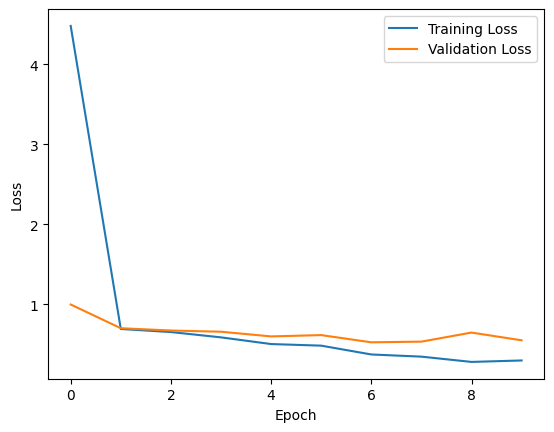

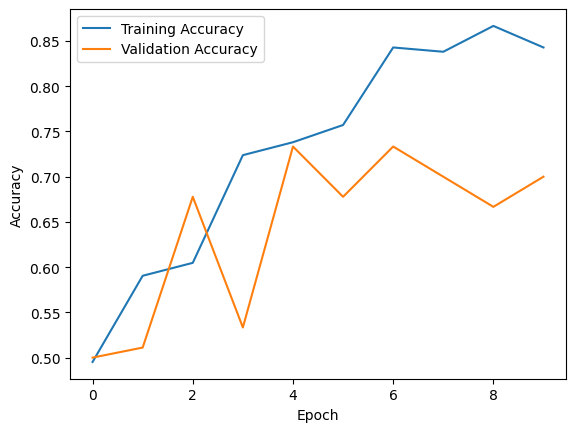

In [26]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 [==============================] - 0s 47ms/step


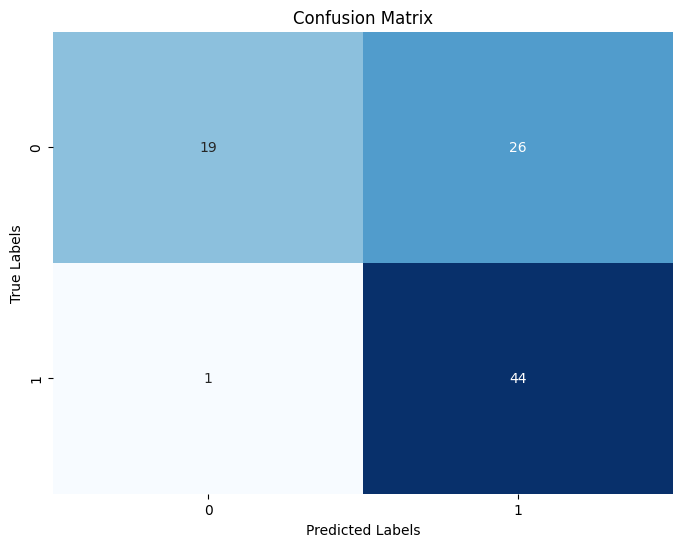

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        45
           1       0.63      0.98      0.77        45

    accuracy                           0.70        90
   macro avg       0.79      0.70      0.67        90
weighted avg       0.79      0.70      0.67        90



In [27]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Print classification report
print("Classification Report:\n", class_report)


In [28]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 6/D/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 6/D/model.h5
